# Setup ML Agents Environment

In [ ]:
env.close()

In [1]:
from mlagents_envs.environment import UnityEnvironment
try:
    env.close()
except:
    pass
# -----------------

env = UnityEnvironment(file_name="../dungeon_nodev/dungeon_escape_nondev")

Found path: /home/reuben/dungeon_testing/../dungeon_nodev/dungeon_escape_nondev.x86_64
Mono path[0] = '/home/reuben/dungeon_testing/../dungeon_nodev/dungeon_escape_nondev_Data/Managed'
Mono config path = '/home/reuben/dungeon_testing/../dungeon_nodev/dungeon_escape_nondev_Data/MonoBleedingEdge/etc'
Preloaded 'lib_burst_generated.so'
Preloaded 'libgrpc_csharp_ext.x64.so'
Initialize engine version: 2020.3.16f1 (049d6eca3c44)
[Subsystems] Discovering subsystems at path /home/reuben/dungeon_testing/../dungeon_nodev/dungeon_escape_nondev_Data/UnitySubsystems
Forcing GfxDevice: Null
GfxDevice: creating device client; threaded=0
NullGfxDevice:
    Version:  NULL 1.0 [1.0]
    Renderer: Null Device
    Vendor:   Unity Technologies
Begin MonoManager ReloadAssembly
- Completed reload, in  0.054 seconds
ERROR: Shader Sprites/Default shader is not supported on this GPU (none of subshaders/fallbacks are suitable)
ERROR: Shader Sprites/Mask shader is not supported on this GPU (none of subshaders/fal

In [61]:
env.reset()

# Behavior Specs

## Get Behavior Specs from Environment

In [62]:
behavior_name = list(env.behavior_specs.keys())[0]
spec = env.behavior_specs[behavior_name]
spec

BehaviorSpec(observation_specs=[ObservationSpec(shape=(10,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.DEFAULT: 0>, name='RBSensor'), ObservationSpec(shape=(360,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.DEFAULT: 0>, name='StackingSensor_size3_RayPerceptionSensor'), ObservationSpec(shape=(1,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.DEFAULT: 0>, name='VectorSensor_size1')], action_spec=ActionSpec(continuous_size=0, discrete_branches=(7,)))

## Get Observation Space from Behavior Specs

In [63]:
# Examine the number of observations per Agent
print("Number of observations : ", len(spec.observation_specs))

# Is there a visual observation ?
# Visual observation have 3 dimensions: Height, Width and number of channels
vis_obs = any(len(spec.shape) == 3 for spec in spec.observation_specs)
print("Is there a visual observation ?", vis_obs)

Number of observations :  3
Is there a visual observation ? False


## Get Action Space from Behavior Specs

In [64]:
# Is the Action continuous or multi-discrete ?
if spec.action_spec.continuous_size > 0:
    print(f"There are {spec.action_spec.continuous_size} continuous actions")
if spec.action_spec.is_discrete():
    print(f"There are {spec.action_spec.discrete_size} discrete actions")


# How many actions are possible ?
#print(f"There are {spec.action_size} action(s)")

# For discrete actions only : How many different options does each action has ?
if spec.action_spec.discrete_size > 0:
    for action, branch_size in enumerate(spec.action_spec.discrete_branches):
        print(f"Action number {action} has {branch_size} different options")

There are 1 discrete actions
Action number 0 has 7 different options


In [65]:
spec.action_spec.discrete_branches[0]

7

## Learning About the Observations for Agents
---
As seen from the cell below, there are 3 sources of observations coming from the `RBSensor`, `RayPerceptionSensor` and `VectorSensor`. The observations have a `batch_size` of 36, stemming from the 3 agents, replicated over 12 learning environments.

* `RBSensor` refers to `RigidBodySensor`, which within the Unity editor tells me this is not useful because this model lacks joints and will always be identity values, can actually be removed.
* The other 2 are useful, but need to think of how to represent them, do I just concatenate them?

In [66]:
import torch as th
decision_steps, terminal_steps = env.get_steps("DungeonEscape?team=0")

# observations coming from 3 sources, in batches of 3 * 12 (replicated envs) = 36
print(decision_steps.obs[0].shape)  # rb_sensor, DO NOT USE
print(decision_steps.obs[1].shape)  # ray perception sensor
print(decision_steps.obs[2].shape)  # vector sensor
print(th.cat((th.tensor(decision_steps.obs[1]), th.tensor(
    decision_steps.obs[2])), 1).shape)

(36, 10)
(36, 360)
(36, 1)
torch.Size([36, 361])


# Learning

## Memory
Using NamedTuples could be a neater method of doing things. Probably can use it for the single agent training.

In [67]:
import numpy as np
from typing import NamedTuple, List, Deque, Dict
from types import SimpleNamespace

class Experience(NamedTuple):
    """
    An experience contains the data of one Agent transition.
    - Observation
    - Action
    - Reward
    - Done flag
    - Next Observation
    """

    obs: np.ndarray
    action: np.ndarray # Check on the actual actions required by Unity
    reward: float
    done: bool
    next_obs: np.ndarray

# Pretty cool, these aren't instantiations but like composite typing
# A Trajectory is an ordered sequence of Experiences
Trajectory = List[Experience] # small enough so I am not afraid of exceeding

# A Buffer is an unordered list of Experiences from multiple Trajectories
Buffer = Deque[Experience]

In [68]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        """
        To deal with the potential changing number of agents, each with valid
        observations -> just store the [36, 361] observations as 36 seperate
        entries, and the 36 actions also as seperate entries... I think...
        """
        self.mem_size = max_size
        self.mem_cntr = 0
#         self.state_memory = np.zeros((self.mem_size, *input_shape),
#                                      dtype=np.float32)
#         self.new_state_memory = np.zeros((self.mem_size, *input_shape),
#                                          dtype=np.float32)
        self.state_memory = np.zeros((self.mem_size, input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, input_shape),
                                         dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

## Models

In [69]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

### Caveat for Linear Layer
As per [pytorch docs](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), input is of shape \[N, *, input_dims\], where * means any number of additional dimensions. So it will implicitly handle our observations of \[32, 36, 361\] by just passing 361 as input dims.

In [70]:
class DQN(nn.Module):
    """
    Currently just boilerplate code, to tweak architecture
    """

    def __init__(self,
                 input_shape: int,
                 hidden_size1: int,
                 hidden_size2: int,
                 output_size: int,
                 args: SimpleNamespace):
        """
        Input to the network will be of shape [B, n_agents, obs_size]
        """
        super().__init__()
        self.args = args
        self.fc1 = nn.Linear(input_shape, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.device = th.device(args.device)
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        q = self.fc3(x)

        # return q-values for actions
        return q 

## Learning Agent

In [71]:
from collections import deque
import random

In [72]:
class DQNAgent:
    def __init__(self, args: SimpleNamespace, env: UnityEnvironment):
        self.args = args
        self.device = th.device(args.device)
        self.epsilon = args.epsilon
        self.eps_min = args.eps_min
        self.eps_dec = args.eps_dec
        self.replace_target_cnt = args.replace
        self.batch_size = args.batch_size
        self.gamma = args.gamma

        # environment related information
        self.env = env
        self.behavior_name = list(env.behavior_specs.keys())[0]
        self.spec = env.behavior_specs[self.behavior_name]
        self.n_actions = self.spec.action_spec.discrete_branches[0]
        self.action_space = [i for i in range(self.n_actions)]

        # RL related
        self.memory: Buffer = deque([], maxlen=args.mem_size)
        self.q_eval = DQN(args.input_shape, args.hidden_size1,
                          args.hidden_size2, args.output_size, args)
        # target network, perhaps can deepcopy?
        self.q_next = DQN(args.input_shape, args.hidden_size1,
                          args.hidden_size2, args.output_size, args)

        self.optimiser = th.optim.Adam(self.q_eval.parameters(), lr=args.lr)
        self.loss = nn.MSELoss()

        self.learn_step_counter = 0

        self._setup_checkpoints_dir(args)

    def _setup_checkpoints_dir(self, args):
        model_name = args.save_name
        save_dir = "./checkpoints/"
        self.chkpts_path = os.path.join(save_dir, model_name)
        if not os.path.isdir(self.chkpts_path):
            os.makedirs(self.chkpts_path)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            # no need to accumulate gradients on inference, and memory stored
            # as numpy ndarrays anyway
            q_vals = self.q_eval.forward(observation).detach().cpu().numpy()
            actions = np.argmax(q_vals, axis=1)
        else:
            actions = np.random.choice(
                self.action_space, size=observation.shape[0])

        return actions

#     def store_transition(self, state, action, reward, state_, done):
#         self.memory.store_transition(state, action, reward, state_, done)
    # NOTE: too cumbersome to handle here now, may come back later

#     def sample_memory(self):
#         state, action, reward, new_state, done = \
#             self.memory.sample_buffer(self.batch_size)

#         states = th.tensor(state).to(self.q_eval.device)
#         rewards = th.tensor(reward).to(self.q_eval.device)
#         dones = th.tensor(done).to(self.q_eval.device)
#         actions = th.tensor(action).to(self.q_eval.device)
#         states_ = th.tensor(new_state).to(self.q_eval.device)

#         return states, actions, rewards, states_, dones

    def sample_memory(self):
#         indices = np.random.choice(len(self.memory), self.args.batch_size)
        batch = random.choices(self.memory, k=self.args.batch_size)
        # Essentially just unpacking the experience
        obs = th.from_numpy(
            np.stack([ex.obs for ex in batch])).to(self.device)
        rewards = th.from_numpy(
            np.array([ex.reward for ex in batch],
                     dtype=np.float32).reshape(-1, 1)
        ).to(self.device)
        dones = th.from_numpy(
            np.array([ex.done for ex in batch],
                     dtype=np.float32).reshape(-1, 1)
        ).to(self.device)
        dones = th.gt(dones, 0) # cast to bool tensor
        actions = th.from_numpy(
            np.stack([ex.action for ex in batch])).to(self.device)
        next_obs = th.from_numpy(
            np.stack([ex.next_obs for ex in batch])).to(self.device)

        return obs, actions, rewards, next_obs, dones

    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
            if self.epsilon > self.eps_min else self.eps_min

    def save_checkpoints(self, num):
        th.save(self.q_next.state_dict(),
                os.path.join(self.chkpts_path, f"qnext_{num}.pt"))
        th.save(self.q_eval.state_dict(),
                os.path.join(self.chkpts_path, f"qeval_{num}.pt"))

    def load_checkpoints(self, num):
        self.q_next.load_state_dict(
            th.load(os.path.join(self.chkpts_path, f"qnext_{num}.pt")))
        self.q_eval.load_state_dict(
            th.load(os.path.join(self.chkpts_path, f"qnext_{num}.pt")))

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        self.optimiser.zero_grad()

        self.replace_target_network()

        states, actions, rewards, states_, dones = self.sample_memory()
        indices = np.arange(self.batch_size)

        q_pred = self.q_eval.forward(states)[indices, actions]
        q_next = self.q_next.forward(states_).max(dim=1)[0]

        dones = th.squeeze(dones, 1)
#         print(q_next.shape)
#         print(dones.shape)
#         print(dones)
        q_next[dones] = 0.0
#         print(q_next)
        q_target = rewards + self.gamma * q_next

        loss = self.loss(q_target, q_pred).to(self.device)
        loss.backward()
        self.optimiser.step()
        self.learn_step_counter += 1

        self.decrement_epsilon()

## Arguments

In [73]:
args = SimpleNamespace()

args.batch_size = 32
args.device = 'cuda:2'
args.epsilon = 1.0
args.gamma = 0.99
args.save_name = 'dqn'
args.lr = 0.0001
args.mem_size = 50000
args.eps_min = 0.1
args.eps_dec = 1e-4
args.replace = 1000
# args.input_shape = (decision_steps.obs[1].shape[0],
#                     decision_steps.obs[1].shape[1] + decision_steps.obs[2].shape[1])
args.input_shape = decision_steps.obs[1].shape[1] + decision_steps.obs[2].shape[1]
args.hidden_size1 = 256
args.hidden_size2 = 128
args.output_size = spec.action_spec.discrete_branches[0]

args

namespace(batch_size=32,
          device='cuda:2',
          epsilon=1.0,
          gamma=0.99,
          save_name='dqn',
          lr=0.0001,
          mem_size=50000,
          eps_min=0.1,
          eps_dec=0.0001,
          replace=1000,
          input_shape=361,
          hidden_size1=256,
          hidden_size2=128,
          output_size=7)

# Playing in the Environment

In [74]:
from mlagents_envs.environment import ActionTuple

Need to find some way to handle cummulative rewards.

In [75]:
from tqdm.notebook import tqdm, trange

In [ ]:
best_score = -np.inf
load_checkpoint = False
n_games = 750

agent = DQNAgent(args, env)

if load_checkpoint:
    agent.load_checkpoints(num=0) # Placeholder

dict_trajectories_from_agent: Dict[int, Trajectory] = {}
dict_last_obs_from_agent: Dict[int, np.ndarray] = {}
dict_last_action_from_agent: Dict[int, np.ndarray] = {}
dict_cumulative_reward_from_agent: Dict[int, float] = {}
cumulative_rewards: List[float] = []

for i in trange(n_games):
    done = False
    env.reset()

    score = 0
    while not done:
        # get observations somehow
        decision_steps, terminal_steps = env.get_steps(agent.behavior_name)
        # --------- Unsure about this, this does things in batch manner -----------
#         ray_obs = th.tensor(decision_steps.obs[1]).to(agent.device)
#         key_obs = th.tensor(decision_steps.obs[2]).to(agent.device)
        # combine observations into 1 vector
        obs = np.concatenate(
            (decision_steps.obs[1], decision_steps.obs[2]), axis=1)
        # -------------------------------------------------------------------------

        # For all Agents with a Terminal Step:
        for agent_id_terminated in terminal_steps:
            # Create its last experience (is last because the Agent terminated)
            last_experience = Experience(
                obs=dict_last_obs_from_agent[agent_id_terminated].copy(),
                reward=terminal_steps[agent_id_terminated].group_reward,
                done=not terminal_steps[agent_id_terminated].interrupted,
                action=dict_last_action_from_agent[agent_id_terminated].copy(),
                next_obs=np.concatenate(
                    (terminal_steps[agent_id_terminated].obs[1],
                     terminal_steps[agent_id_terminated].obs[2]), axis=0)
            )
            # Clear its last observation and action (Since the trajectory is over)
            dict_last_obs_from_agent.pop(agent_id_terminated)
            dict_last_action_from_agent.pop(agent_id_terminated)

            cumulative_reward = (
                dict_cumulative_reward_from_agent.pop(agent_id_terminated)
                + terminal_steps[agent_id_terminated].group_reward
            )
            cumulative_rewards.append(cumulative_reward)

            agent.memory.extend(dict_trajectories_from_agent.pop(
                agent_id_terminated))
            agent.memory.append(last_experience)

        # For all Agents with a Decision Step:
        for agent_id_decisions in decision_steps:
            # If the Agent does not have a Trajectory, create an empty one
            if agent_id_decisions not in dict_trajectories_from_agent:
                dict_trajectories_from_agent[agent_id_decisions] = []
                dict_cumulative_reward_from_agent[agent_id_decisions] = 0

            # If the Agent requesting a decision has a "last observation"
            if agent_id_decisions in dict_last_obs_from_agent:
                # Create an Experience from the last observation and the Decision Step
                exp = Experience(
                    obs=dict_last_obs_from_agent[agent_id_decisions].copy(),
                    reward=decision_steps[agent_id_decisions].group_reward,
                    done=False,
                    action=dict_last_action_from_agent[agent_id_decisions].copy(
                    ),
                    next_obs=np.concatenate((decision_steps[agent_id_decisions].obs[1],
                                            decision_steps[agent_id_decisions].obs[2]), axis=0)
                )
#                 print(exp.next_obs)
                # Update the Trajectory of the Agent and its cumulative reward
                dict_trajectories_from_agent[agent_id_decisions].append(exp)
                dict_cumulative_reward_from_agent[agent_id_decisions] += (
                    decision_steps[agent_id_decisions].group_reward
                )
#             print(decision_steps[agent_id_decisions].obs[1].shape)
#             print(decision_steps[agent_id_decisions].obs[2].shape)
            dict_last_obs_from_agent[agent_id_decisions] = np.concatenate((decision_steps[agent_id_decisions].obs[1],
                                                                           decision_steps[agent_id_decisions].obs[2]), axis=0)

        # when passing to agent in "live" env, bs is 1
        # number of actions obtained = number of agents remaining alive
        with th.no_grad():
            # performing inference, don't want to accumulate gradients
            actions = agent.choose_action(
                th.from_numpy(obs).to(agent.device))
        actions.resize(len(decision_steps), 1)
        # Store the action that was picked, it will be put in the trajectory later
        for agent_index, agent_id in enumerate(decision_steps.agent_id):
            dict_last_action_from_agent[agent_id] = actions[agent_index]

        # Set the actions in the environment
        # Unity Environments expect ActionTuple instances.
        action_tuple = ActionTuple()
        action_tuple.add_discrete(actions)
#         print(action_tuple._discrete.shape)
        env.set_actions(agent.behavior_name, action_tuple)
        env.step()
        
        agent.learn()
        
        if len(decision_steps) == 0:
            done = True
        
    if i % 25 == 0 or i == n_games-1:
        print(f'At game {i}, epsilon={agent.epsilon}')
        agent.save_checkpoints(num=i)

  0%|          | 0/750 [00:00<?, ?it/s]

ERROR: Shader UI/Default shader is not supported on this GPU (none of subshaders/fallbacks are suitable)
Dragon ate DungeonEscapeAgent (2)

At game 0, epsilon=1.0
Dragon ate DungeonEscapeAgent (2)

Dragon ate DungeonEscapeAgent

Dragon ate DungeonEscapeAgent (2)

Dragon ate DungeonEscapeAgent (1)

Dragon ate DungeonEscapeAgent

Dragon ate DungeonEscapeAgent (1)

Picked up key

Picked up key

Picked up key

Dragon ate DungeonEscapeAgent

Dragon ate DungeonEscapeAgent (1)

Picked up key

Dragon ate DungeonEscapeAgent (1)

Picked up key

Picked up key

Dragon ate DungeonEscapeAgent

Picked up key

At game 25, epsilon=0.9692000000000034
Dragon ate DungeonEscapeAgent (1)

Picked up key

Picked up key

Dragon ate DungeonEscapeAgent (1)

Dragon ate DungeonEscapeAgent

Dragon ate DungeonEscapeAgent (2)

Picked up key

Internal: JobTempAlloc has allocations that are more than 4 frames old - this is not allowed and likely a leak

Internal: deleting an allocation that is older than its permitted 

2104
(array([ 246,  247,  425,  426,  514,  515,  540,  606,  607,  672,  673,
        857,  858, 1082, 1083, 1326, 1650, 1651, 1822, 1823, 1857, 1858]),)


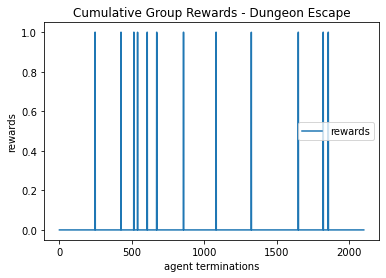

In [4]:
import matplotlib.pyplot as plt
import numpy as np

cumulative_rewards = np.load('./results/dungeon/dqn_cum_rewards.npy')
print(len(cumulative_rewards))
plt.plot(np.arange(len(cumulative_rewards)), cumulative_rewards, label='rewards')
plt.title('Cumulative Group Rewards - Dungeon Escape')
plt.ylabel('rewards')
plt.xlabel('agent terminations')
plt.legend()
plt.savefig('./plots/dungeon/dqn_cum_rewards.png')
print(np.nonzero(cumulative_rewards))


2104
(array([ 246,  247,  425,  426,  514,  515,  540,  606,  607,  672,  673,
        857,  858, 1082, 1083, 1326, 1650, 1651, 1822, 1823, 1857, 1858]),)


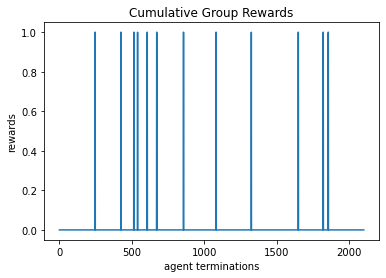

In [89]:
import matplotlib.pyplot as plt

print(len(cumulative_rewards))
plt.plot(np.arange(len(cumulative_rewards)), cumulative_rewards)
plt.title('Cumulative Group Rewards')
plt.ylabel('rewards')
plt.xlabel('agent terminations')
plt.savefig('./plots/dungeon/dqn_cum_rewards.png')
print(np.nonzero(cumulative_rewards))

np.save('./results/dungeon/dqn_cum_rewards.npy', cumulative_rewards)

In [85]:
rewards = [memory.reward for memory in agent.memory]
print(np.nonzero(rewards)) # all positive rewards got pushed out of this buffer
print(len(agent.memory))

(array([], dtype=int64),)
50000


# Wrapping Up, Closing the Environment
Without closing the environment, we cannot make the environment again. Unity will complain about the communicator already being in use.

In [86]:
env.close()

Setting up 10 worker threads for Enlighten.
  Thread -> id: 7f89e25b9700 -> priority: 1 
  Thread -> id: 7f89e1db8700 -> priority: 1 
  Thread -> id: 7f89e15b7700 -> priority: 1 
  Thread -> id: 7f89e0db6700 -> priority: 1 
  Thread -> id: 7f8957fff700 -> priority: 1 
  Thread -> id: 7f89577fe700 -> priority: 1 
  Thread -> id: 7f8956ffd700 -> priority: 1 
  Thread -> id: 7f89567fc700 -> priority: 1 
  Thread -> id: 7f8955ffb700 -> priority: 1 
  Thread -> id: 7f89557fa700 -> priority: 1 


# QMIX